In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
class Value:
    def __init__(self,data, _children=(), _op = '', label = ''): 
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._grad = 0 
        self._backward = lambda: None

    def __repr__(self): #If this is not present, the values would be printed out in an ugly manner
        return f"Value(data = {self.data})"

    def __add__(self, other): # addition
        other = other if isinstance (other, Value) else Value(other) #converts the other number into a value class if not already done.
        out = Value(self.data + other.data, (self, other), '+') #adding and feeding the children and previous values

        def _backward():
            self._grad += 1.0 * out._grad
            other._grad += 1.0 * out._grad
            
        out._backward = _backward 
        return out

    def __radd__(self, other): #other + self
        return self + other

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

        
    def __mul__(self, other): #multiplication
        other = other if isinstance (other, Value) else Value(other) #converts the other number into a value class if not already done.
        out = Value(self.data * other.data, (self, other), '*') #adding and feeding the children and previous values
        
        def _backward():
            self._grad += other.data * out._grad
            other._grad += self.data  * out._grad
            
        out._backward = _backward
        return out

    def __rmul__(self, other): #other * self
        return self * other

    def __truediv__(self, other): #division (a x b^-1)
        return self * (other**-1)

    def exp(self): #exponent
        out = Value(math.exp(self.data), (self, ), 'exp')

        def _backward():
            self._grad +=  out.data * out._grad
        out._backward = _backward
        return out

    def __pow__(self, other): #power
        assert isinstance (other, (int, float)), "only supporting int and flaot powers"
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self._grad += (other * self.data**(other - 1)) * out._grad
        out._backward = _backward
        return out
        
    def tanh(self):
        out = Value((math.exp(self.data * 2) - 1) / (math.exp(self.data * 2) + 1), (self, ), 'tanh')
        
        def _backward():
            self._grad += (1 - out.data**2) * out._grad
            
        out._backward = _backward
        return out

    def backward(self):
        topo = [] #building a topo list
        visited = set() #building a visited set to keep track of which nodeshave already been visited.
        def build_topo(v):
            if v not in visited:
                visited.add(v) # adding in visited if the node has not already been visited
                for child in v._prev:
                    build_topo(child) # recursive function till the end
                topo.append(v) # adding the values in the topo list
        build_topo(self) # calling after the function is defined
    
        self._grad = 1.0 # setting the gradient of the farthest child node as 1 for calculating gradients
        for node in reversed(topo): # since the elements in the topo are in the reversed order (starting from basic inputs)
            node._backward() # calling every nodes' ._backward() function
            
# Children keeps track of what values produces what other values
# prev is a set that tracks of the previous values
# op keeps track of the operations' labels for the user to understand easily
# label helps us keep track of variable names 
# _backward keeps track of the input and output gradients so that it is useful to calculate every variable's gradients. The labda is set to None by default
'''
grad is used for gradient descents and differentiation
kept 0 which symbolises that gradient would not have an effect on the output value initially,
which is noramlly the case in backprop.
''' 

'''
for calculating gardients in an additon operation, we know that the gradients are simple passed down from the child node to the parent node.
therefore, defining a function for calculating backward propogation, _backward.
what this does is, it calculates the gradients for the two inputs by multiplying the data of the child (child.data) to 1.
because thats what it basically does hahaha.
'''

'''
for calculating gardients in an multiplication operation, we know that the gradients are simply the product of the data of their other equivalent node and the gradient of their child node.
therefore, defining a function for calculating backward propogation, _backward.
what this does is, it calculates the gradients for the two inputs by multiplying the data of the equivalent node (equivalent.data) to the child node gradient.
'''

'''
THERES A BUG HERE. Basically, we have been using variables that are used just once. therefore, their gradient was only taken into account for one time only.

but now if we have variables,  let's a and b and b = a + a. the analytical derivative of this would be 2 (db / da).
but our derivative function only counts it once. therefore, the gradients need to be accumulated at a place for further addition.

thus, we add and evaluate everybody's gradients. putting += in the ._backward function of every operation, instead of the traditional +
'''

"\nTHERES A BUG HERE. Basically, we have been using variables that are used just once. therefore, their gradient was only taken into account for one time only.\n\nbut now if we have variables,  let's a and b and b = a + a. the analytical derivative of this would be 2 (db / da).\nbut our derivative function only counts it once. therefore, the gradients need to be accumulated at a place for further addition.\n\nthus, we add and evaluate everybody's gradients. putting += in the ._backward function of every operation, instead of the traditional +\n"

In [3]:
from graphviz import Digraph

def trace(root):
    #builds a set of all the nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'}) #LR - left to right

    nodes, edges= trace(root)
    for n in nodes:
        uid = str(id(n))
        #for value in the graph, create a rectangular record for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n._grad), shape = 'record')

        if n._op:
            # if this value is a result of some operation, create a node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this with an edge
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connecting n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [4]:
#inout x1, x2 and weights w1, w2

x1 = Value(2.0, label = 'x1')
w1 = Value(-3.0, label = 'w1')
x2 = Value(0.0, label = 'x2')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.88137, label = 'bias')

#calculation of a neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); label = 'o'

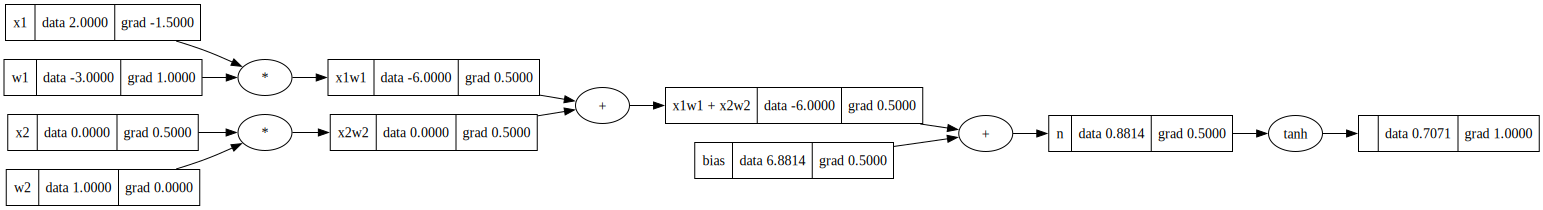

In [5]:
o.backward()
draw_dot(o)

LITERALLY COPIED THE CODE FROM "karpathy 003" file.

NOW WE DEFINE THE EXP AND DIVISION FUNCTION IN THE VALUE CLASS TO COVER ALL THE BASIC FUNCTIONS REQUIRED IN BACKPROP. THE CHANGES CAN BE SEEN IN CELL 88

NOW IMPLEMENTING THE SAME tanh FUNCTION BUT USING THE BASIC FORMULAS

Derivative of tanh:

d (tanh x) / dx = (e^2x - 1) / (e^2x + 1)

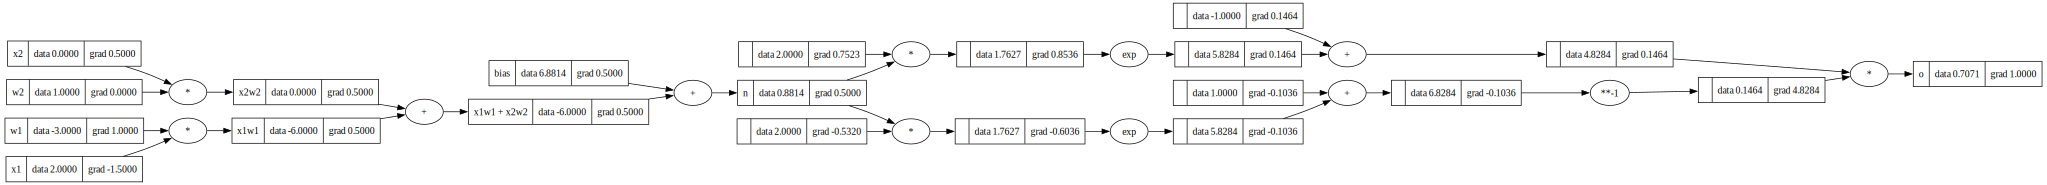

In [6]:
#inout x1, x2 and weights w1, w2

x1 = Value(2.0, label = 'x1')
w1 = Value(-3.0, label = 'w1')
x2 = Value(0.0, label = 'x2')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.88137, label = 'bias')

#calculation of a neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = ((2*n).exp() - 1) / ((2*n).exp() + 1); o.label = 'o'

o.backward()
draw_dot(o)